# Initializing Hydrological Models in CONFLUENCE

## Introduction

This notebook guides you through the process of initializing hydrological models within the CONFLUENCE framework. Model initialization is a critical step that sets up the model structure, parameters, and initial conditions for simulation.

Key steps covered in this notebook include:

1. Performing initial test runs to ensure proper setup.
2. Vizualise initial output.

In this notebook we focus on initializing the primary model chosen for your project, but the principles can be applied to other  models as well. By the end of this notebook, your model will be fully initialized and running.

## First we import the libraries and functions we need

In [ ]:
import sys
from pathlib import Path
from typing import Dict, Any
import logging
import yaml # type: ignore

current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
sys.path.append(str(parent_dir))

from utils.models_utils.model_utils import SummaRunner, MizuRouteRunner # type: ignore
from utils.report_utils.reporting_utils import VisualizationReporter

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Check configurations

Now we should print our configuration settings and make sure that we have defined all the settings we need. 

In [2]:
config_path = Path('../../0_config_files/config_active.yaml')
with open(config_path, 'r') as config_file:
    config = yaml.safe_load(config_file)
    print(f"FORCING_DATASET: {config['FORCING_DATASET']}")
    print(f"EASYMORE_CLIENT: {config['EASYMORE_CLIENT']}")
    print(f"FORCING_VARIABLES: {config['FORCING_VARIABLES']}")
    print(f"EXPERIMENT_TIME_START: {config['EXPERIMENT_TIME_START']}")
    print(f"EXPERIMENT_TIME_END: {config['EXPERIMENT_TIME_END']}")

FORCING_DATASET: ERA5
EASYMORE_CLIENT: easymore cli
FORCING_VARIABLES: longitude,latitude,time,LWRadAtm,SWRadAtm,pptrate,airpres,airtemp,spechum,windspd
EXPERIMENT_TIME_START: 2008-01-01 00:00
EXPERIMENT_TIME_END: 2022-12-31 23:00


## Define default paths

Now let's define the paths to data directories before we run the pre processing scripts and create the containing directories

In [3]:
# Main project directory
data_dir = config['CONFLUENCE_DATA_DIR']
project_dir = Path(data_dir) / f"domain_{config['DOMAIN_NAME']}"

# Data directoris
simulation_dir = project_dir / 'simulations' / f"{config['EXPERIMENT_ID']}"
hydro_model_dir = simulation_dir / f"{config['HYDROLOGICAL_MODEL']}"
routing_model_dir = simulation_dir / f"{config['ROUTING_MODEL']}"

# Make sure the new directories exists
hydro_model_dir.mkdir(parents = True, exist_ok = True)
routing_model_dir.mkdir(parents = True, exist_ok = True)

## 1. Initalize hydrological model runs

In [4]:
# Initialize model specific preprocessors
if config['HYDROLOGICAL_MODEL'] == 'SUMMA':
    sr = SummaRunner(config, logger)
    spatial_results = sr.run_summa()
    if config['DOMAIN_DEFINITION_METHOD'] != 'lumped': # lumped domain definition has no routing
        mr = MizuRouteRunner(config, logger)
        streamflow_results = mr.run_mizuroute()

2025-07-10 13:25:15,001 - INFO - Starting SUMMA run
2025-07-10 13:25:16,672 - INFO - SUMMA run completed successfully


## 2. Visualize results

In [10]:
# Initialize time series visualizer
vr = VisualizationReporter(config, logger)

# Create visualization
if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / config['EXPERIMENT_ID'] / "mizuRoute" / f"{config['EXPERIMENT_ID']}.nc"))]
else: # lumped domain definition has no routing
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / config['EXPERIMENT_ID'] / config['HYDROLOGICAL_MODEL'] / f"{config['EXPERIMENT_ID']}_timestep.nc"))]
obs_files = [('Observed', str(project_dir / "observations" / "streamflow" / "preprocessed" / f"{config.get('DOMAIN_NAME')}_streamflow_processed.csv"))]
plot_file = vr.plot_streamflow_simulations_vs_observations(model_outputs, obs_files)

if plot_file:
    logger.info(f"Streamflow comparison plot saved to: {plot_file}")
else:
    logger.error("Failed to create streamflow comparison plot")

# Optional: Display the plot in the notebook
from IPython.display import Image
Image(filename=plot_file)

2025-09-08 20:42:02,225 - WARNING - Could not read simulation file /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/simulations/run_1/SUMMA/run_1_timestep.nc: [Errno -101] NetCDF: HDF error: '/Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/simulations/run_1/SUMMA/run_1_timestep.nc'
2025-09-08 20:42:02,226 - ERROR - No simulation data could be loaded
2025-09-08 20:42:02,227 - ERROR - Failed to create streamflow comparison plot


ValueError: No image data found. Expecting filename, url, or data.

In [11]:
# Initialize time series visualizer for glacier version
vr = VisualizationReporter(config, logger)

# Create visualization
if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / f"{config['EXPERIMENT_ID']}_glac" / "mizuRoute" / f"{config['EXPERIMENT_ID']}.nc"))]
else: # lumped domain definition has no routing
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / f"{config['EXPERIMENT_ID']}_glac" / config['HYDROLOGICAL_MODEL'] / f"{config['EXPERIMENT_ID']}_timestep.nc"))]
obs_files = [('Observed', str(project_dir / "observations" / "streamflow" / "preprocessed" / f"{config.get('DOMAIN_NAME')}_streamflow_processed.csv"))]
plot_file = vr.plot_streamflow_simulations_vs_observations(model_outputs, obs_files)

if plot_file:
    logger.info(f"Streamflow comparison plot saved to: {plot_file}")
else:
    logger.error("Failed to create streamflow comparison plot")

# Optional: Display the plot in the notebook
from IPython.display import Image
Image(filename=plot_file)

2025-09-08 20:42:05,758 - WARNING - Could not read simulation file /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/simulations/run_1_glac/SUMMA/run_1_timestep.nc: no files to open
2025-09-08 20:42:05,759 - ERROR - No simulation data could be loaded
2025-09-08 20:42:05,760 - ERROR - Failed to create streamflow comparison plot


ValueError: No image data found. Expecting filename, url, or data.

## 3. Visualize results with all versions on same plot

In [ ]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize

plot_folder = project_dir / "plots" / "results"
plot_folder.mkdir(parents=True, exist_ok=True)
change_type = "_FLO" # if you want to change the file type to _VA.nc or _FLO.nc
settings = project_dir / "settings" / config['HYDROLOGICAL_MODEL']

if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
    folder = project_dir / "simulations" / config['EXPERIMENT_ID'] / "mizuRoute"
    folder_glac = project_dir / "simulations" / f"{config['EXPERIMENT_ID']}_glac" / "mizuRoute"
else: # lumped domain definition has no routing
    folder = project_dir / "simulations" / f"{config['EXPERIMENT_ID']}" / config['HYDROLOGICAL_MODEL']
    folder_glac = project_dir / "simulations" / f"{config['EXPERIMENT_ID']}_glac" / config['HYDROLOGICAL_MODEL']
model_outputs_sunenthalpy = [(f"{config['HYDROLOGICAL_MODEL']}", str(folder / "sun5_enthalpyForm" / f"{config['EXPERIMENT_ID']}_timestep.nc"))]
model_outputs_glac_sunenthalpy = [(f"{config['HYDROLOGICAL_MODEL']}", str(folder_glac / "sun5_enthalpyForm" / f"{config['EXPERIMENT_ID']}_timestep")+change_type+".nc")]
model_outputs_beenthalpy = [(f"{config['HYDROLOGICAL_MODEL']}", str(folder / "be1_enthalpyForm" / f"{config['EXPERIMENT_ID']}_timestep.nc"))]
model_outputs_glac_beenthalpy = [(f"{config['HYDROLOGICAL_MODEL']}", str(folder_glac / "be1_enthalpyForm" / f"{config['EXPERIMENT_ID']}_timestep")+change_type+".nc")]

obs_files = [('Observed', str(project_dir / "observations" / "streamflow" / "preprocessed" / f"{config.get('DOMAIN_NAME')}_streamflow_processed.csv"))]n"

In [468]:
def get_NSE(obs,sim, transfo = 1): 

    obs = np.array(obs)
    sim = np.array(sim)

    isNotNA = np.invert(np.logical_or(np.isnan(obs), np.isnan(sim)))

    obs = obs[isNotNA]
    sim = sim[isNotNA]

    if transfo < 0:
        epsilon =  np.mean(obs)/100
    else:
        epsilon = 0

    obs    = (epsilon + obs) ** transfo
    sim    = (epsilon + sim) ** transfo

    nse    = 1-(np.sum(np.subtract(obs,sim)**2)/np.sum(np.subtract(obs, np.mean(sim))**2))

    return nse

In [469]:
def calculate_metrics(obs: np.ndarray, sim: np.ndarray) -> dict:
    return {
        #'RMSE': get_RMSE(obs, sim, transfo=1),
        #'KGE': get_KGE(obs, sim, transfo=1),
        #'KGEp': get_KGEp(obs, sim, transfo=1),
        'NSE': get_NSE(obs, sim, transfo=1),
        #'MAE': get_MAE(obs, sim, transfo=1),
        #'KGEnp': get_KGEnp(obs, sim, transfo=1)
    }

In [ ]:
def _add_overall_metrics(ax, obs_data, sim_data):
     """Helper method to add overall metrics to the plot"""
     for i, (sim_name, sim) in enumerate(sim_data):
         sim.index = sim.index.round(freq='h')
         if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
             var = 'IRFroutedRunoff'
         else: # lumped domain definition has no routing, assume 1 GRU
             var = 'averageRoutedRunoff'
         aligned_data = pd.merge(obs_data[0][1], sim[var], 
                                 left_index=True, right_index=True, how='inner')
         metrics = calculate_metrics(aligned_data.iloc[:, 0].values, aligned_data.iloc[:, 1].values)
         
         metric_text = f"{sim_name} Metrics:n"
         metric_text += "n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
         
         ax.text(0.02, 0.98 - 0.15 * i, metric_text,
                 transform=ax.transAxes, verticalalignment='top', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=3))

In [471]:
# Read simulation data first
sim_data = []
name = ["be1Mixed","be1Mixed_glac","enthalpy", "enthalpy_glac"]
for i, model_output in enumerate([model_outputs_beenthalpy, model_outputs_glac_beenthalpy,model_outputs_sunenthalpy, model_outputs_glac_sunenthalpy]): 
    for sim_name, sim_file in model_output:
        ds = xr.open_mfdataset(sim_file, engine='netcdf4')
        if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
            basinID = int(config.get('SIM_REACH_ID'))  
            segment_index = ds['reachID'].values == basinID
            ds = ds.sel(seg=ds['seg'][segment_index])
            var = 'IRFroutedRunoff'
        else: # lumped domain definition has no routing, assume 1 GRU
            basinID = 0 # assume 1 GRU
            ds = ds.sel(gru=ds['gru'][basinID])
            var = 'averageRoutedRunoff' # m/s
            area = ds['HRUarea'].values.sum() # m2
        df = ds[var].to_dataframe().reset_index()
        if config['DOMAIN_DEFINITION_METHOD'] == 'lumped':
            df['averageRoutedRunoff'] = df['averageRoutedRunoff'] * area
        df.set_index('time', inplace=True)
        sim_data.append((sim_name+name[i], df))

# Try to read observation data
obs_data = []
for obs_name, obs_file in obs_files:
    df = pd.read_csv(obs_file, parse_dates=['datetime'])
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df['discharge_cms'].resample('h').mean()
    obs_data.append((obs_name, df))

# Determine time range based on simulations, remove 180 days of spin-up
start_date = max([data.index.min() for _, data in sim_data]) + pd.Timedelta(180, unit="d") #+ pd.Timedelta(365, unit="d") 
end_date = min([data.index.max() for _, data in sim_data])

# Filter simulation data to closed time range
sim_data = [(name, data.loc[start_date:end_date]) for name, data in sim_data]

# Filter observation data if it exists
if obs_data:
    obs_data = [(name, data.loc[start_date:end_date]) for name, data in obs_data]

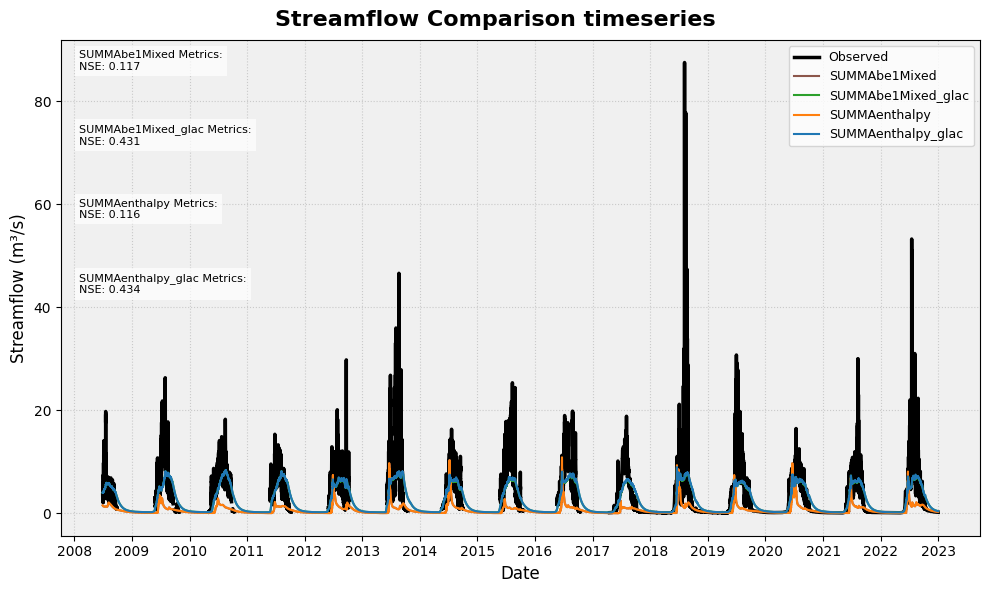

In [472]:
# Create plot
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.suptitle("Streamflow Comparison timeseries", fontsize=16, fontweight='bold')

# Plot time series
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
#linestyles = ['--', '-.', '-', ':', (0, (3, 5, 1, 5)), (0, (5, 10))]
colors = [ '#8c564b', '#2ca02c','#ff7f0e', '#1f77b4', '#d62728', '#9467bd'] 
linestyles = ['-', '-', '-', '-','-', '-']
              
# Plot observations if available
if obs_data:
    for obs_name, obs in obs_data:
        ax1.plot(obs.index, obs, label=f'{obs_name}', color='black', linewidth=2.5)

# Plot simulations
for (sim_name, sim), color, linestyle in zip(sim_data, colors, linestyles):
    ax1.plot(sim.index, sim[var], label=f'{sim_name}', 
            color=color, linestyle=linestyle, linewidth=1.5)
# Add metrics if observations are available
if obs_data:
    _add_overall_metrics(ax1, obs_data, sim_data)

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Streamflow (m³/s)', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_facecolor('#f0f0f0')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
# Save the plot
fig.savefig(plot_folder / 'streamflow_comparison_all.png', dpi=300, bbox_inches='tight')


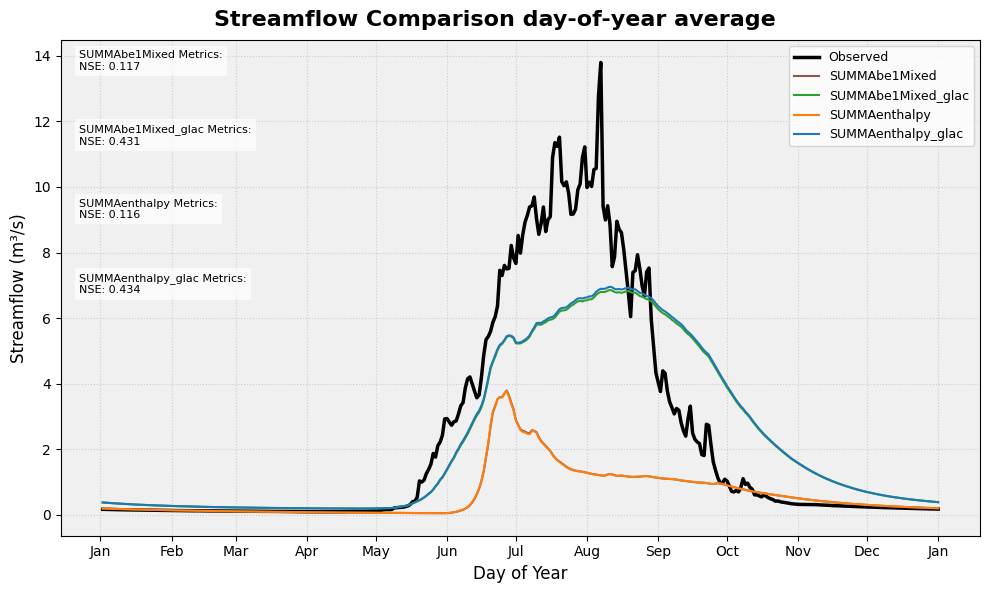

In [473]:
# Create plot
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.suptitle("Streamflow Comparison day-of-year average", fontsize=16, fontweight='bold')

# Plot observations if available
if obs_data:
    for obs_name, obs in obs_data:
        obs = obs[obs.index.dayofyear != 366]
        day_of_year_avg = obs.groupby(obs.index.dayofyear).mean()
        ax1.plot(day_of_year_avg.index, day_of_year_avg, label=f'{obs_name}', color='black', linewidth=2.5)


# Plot simulations
for (sim_name, sim), color, linestyle in zip(sim_data, colors, linestyles):
    sim = sim[sim.index.dayofyear != 366]
    day_of_year_avg = sim.groupby(sim.index.dayofyear).mean()
    ax1.plot(day_of_year_avg.index, day_of_year_avg[var], label=f'{sim_name}', 
            color=color, linestyle=linestyle, linewidth=1.5)
    
# Add metrics if observations are available
if obs_data:
    _add_overall_metrics(ax1, obs_data, sim_data)

ax1.set_xlabel('Day of Year', fontsize=12)
ax1.set_ylabel('Streamflow (m³/s)', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, linestyle=':', alpha=0.55)
ax1.set_facecolor('#f0f0f0')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Save the plot
fig.savefig(plot_folder / f'streamflow_comparison_all_wy.png', dpi=300, bbox_inches='tight')

In [ ]:
# Plot glacier surface change
attrib_grid = settings / "attributes_glacBedTopo.nc"
start_grid = settings / "coldState_glacSurfTopo.nc"
surface_grid = str( f"{config['EXPERIMENT_ID']}_restartGrid")
model_outputs_glac_beenthalpy = [(f"{config['HYDROLOGICAL_MODEL']}", str(folder_glac / "be1_enthalpyForm/Restarts"))]
model_outputs_glac_sunenthalpy = [(f"{config['HYDROLOGICAL_MODEL']}", str(folder_glac / "sun5_enthalpyForm/Restarts"))]  

# Parameters for plotting
viridis = plt.get_cmap('viridis')
viridis_r = viridis.reversed()
# Create a new colormap with 0 values set to white
colors = viridis_r(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]  # Set the first color (0 value) to white
custom_cmap = LinearSegmentedColormap.from_list('custom_viridis_r', colors)
plot_diff_debris = False # plot difference in debris thickness instead of absolute values

# Determine number of years based on number of files
nYears = 0
for ii, model_output in enumerate([model_outputs_glac_beenthalpy,model_outputs_glac_sunenthalpy]): 
    # Find number of years based on number of files
    dir = Path(model_output[0][1])
    files = list(dir.glob(f"*{surface_grid}*"))
    nYears = max(nYears, len(files))
nYears = nYears + 1 # add one for the start grid

ds_init = xr.open_mfdataset(attrib_grid, engine='netcdf4')
nGru = int(len(ds_init['gruId'].values))

Processing model output: /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Gulkana/simulations/run_1_glac/SUMMA/sun5_enthalpyForm/Restarts


/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:91: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(debris)
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:92: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(debris)
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:91: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(debris)
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:92: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(debris)
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:91: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(debris)
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:92: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(debris)
/var/folders/vg/2cv5b92d4216qkxz87hgmv7r0000kp/T/ipykernel_88118/2112461436.py:91: Runti

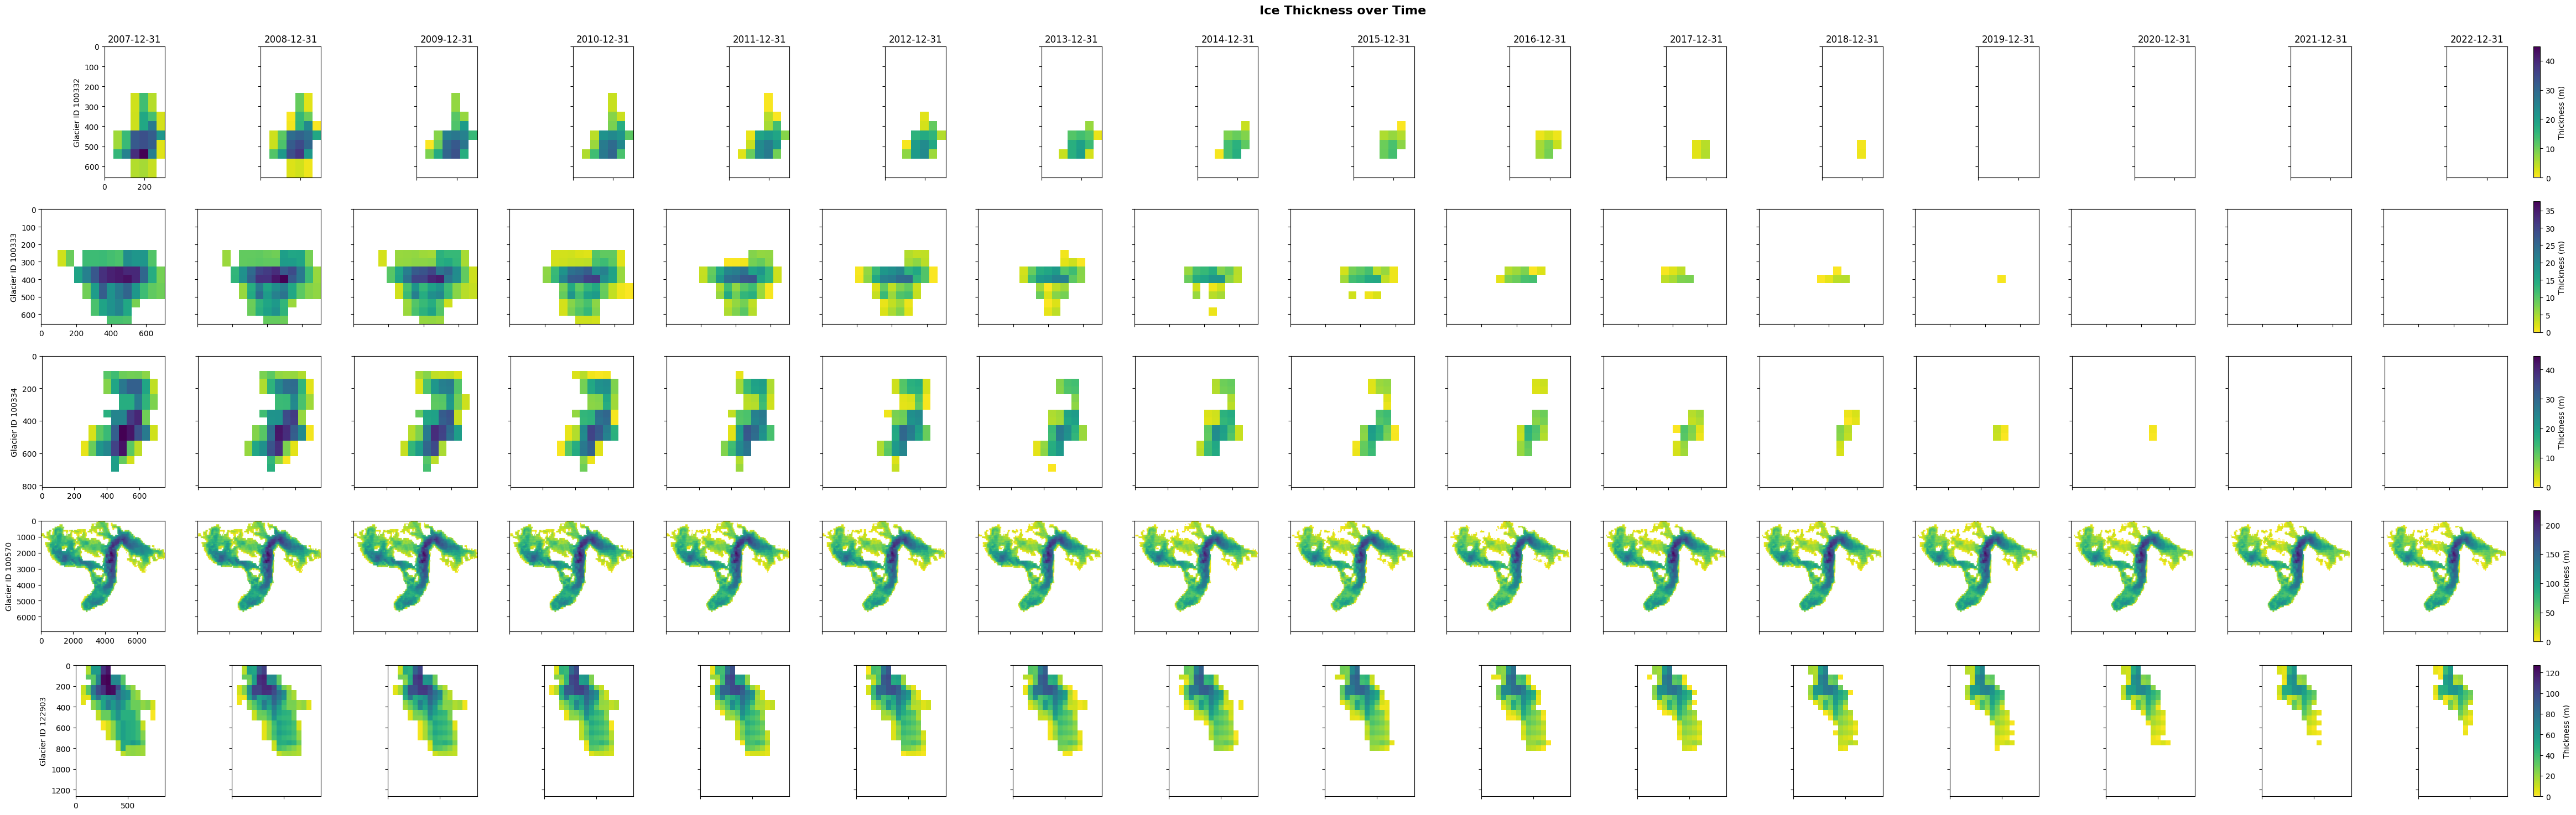

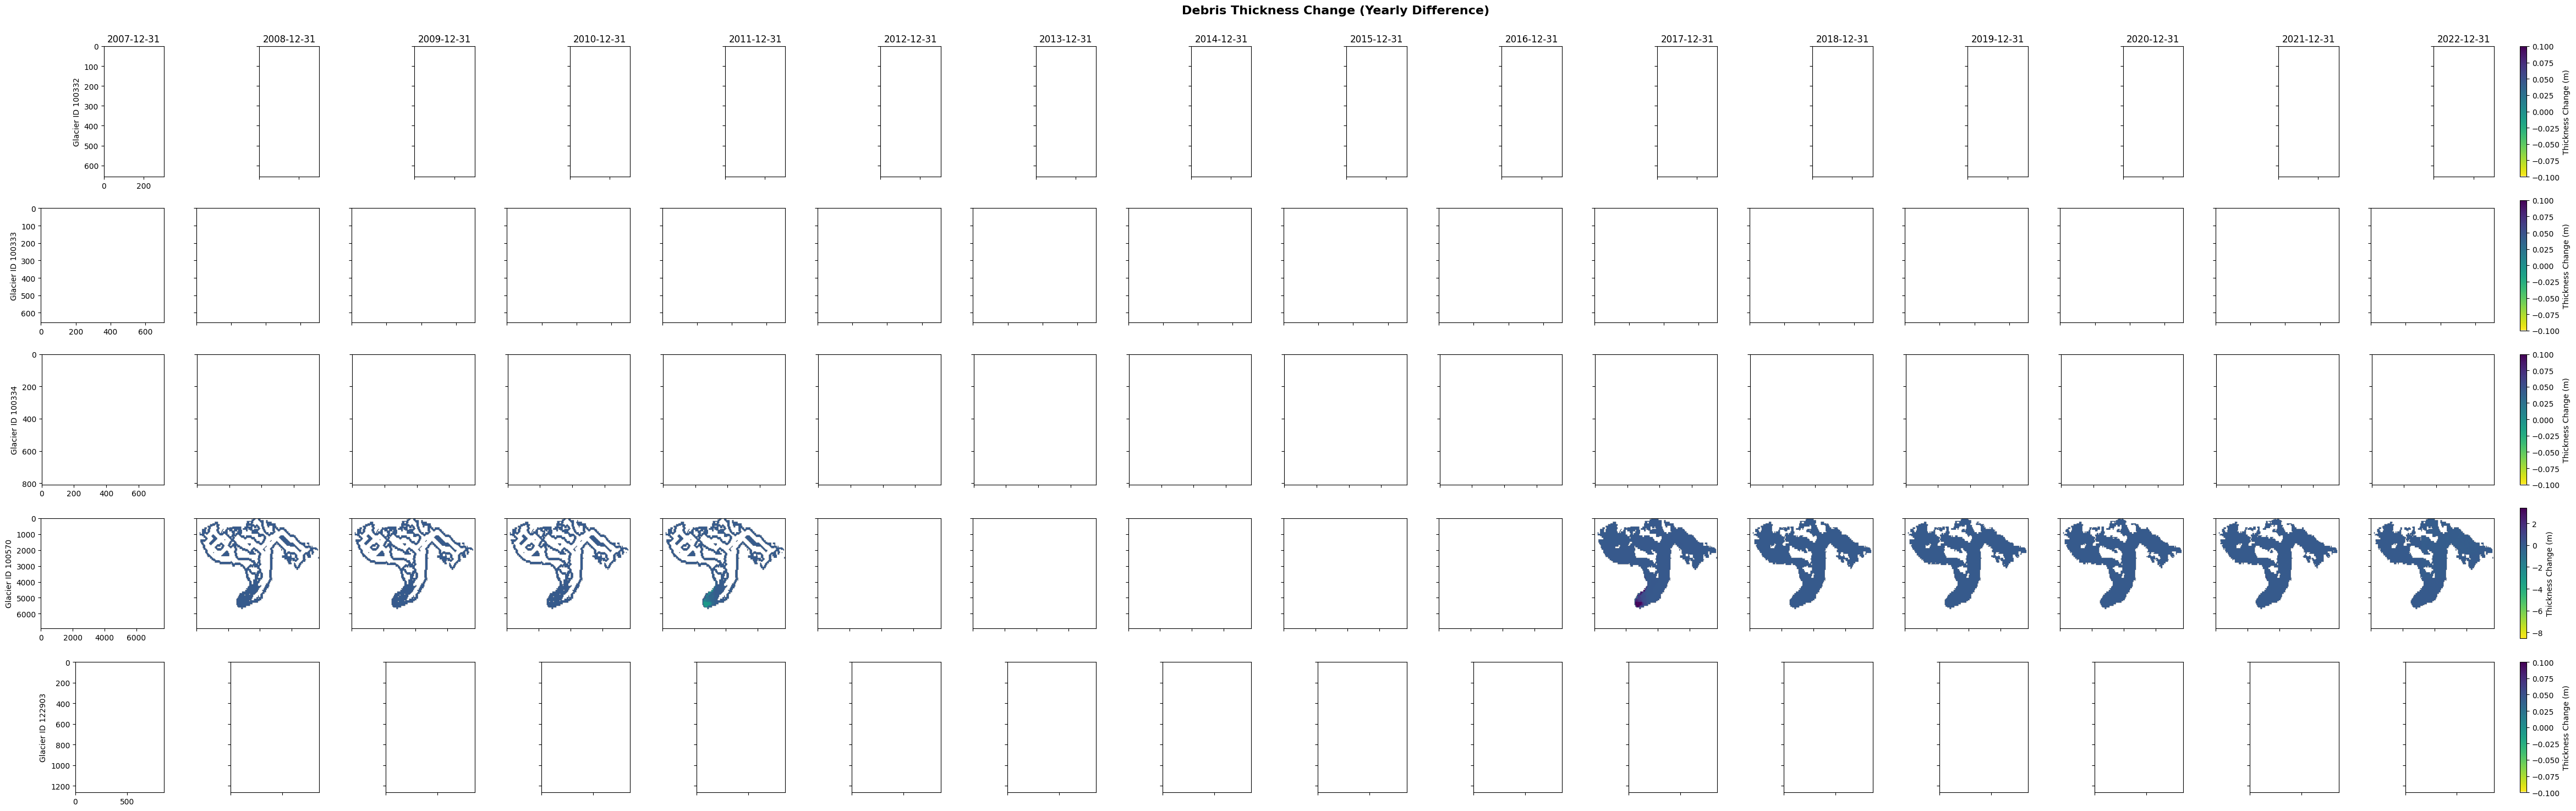

In [557]:
# Loop over model outputs (maybe just one is fine)
for ii, model_output in enumerate([model_outputs_glac_sunenthalpy]):
    print(f"Processing model output: {model_output[0][1]}")
    dir = Path(model_output[0][1])
    files = list(dir.glob(f"*{surface_grid}*"))
    files.sort()
    # add start grid at the beginning
    files = [start_grid] + files
    for j in range(nGru):
        gruID = int(ds_init['gruId'].values[j])
        ds_sel = ds_init.sel(gru=ds_init['gru'][j])
        nGlac = int(ds_sel['nGrid'].values)
        fig1, axs1 = plt.subplots(nGlac, nYears, figsize=(3*nYears, 3*nGlac))
        fig1.suptitle("Ice Thickness over Time", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        fig2, axs2 = plt.subplots(nGlac, nYears, figsize=(3*nYears, 3*nGlac))
        if plot_diff_debris:
            fig2.suptitle("Debris Thickness Change (Yearly Difference)", fontsize=16, fontweight='bold')     
        else:
            fig2.suptitle("Debris Thickness over Time", fontsize=16, fontweight='bold')     
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)

        for i in range(nGlac):
            # get  bed topography and glacier mask
            glacID = int(ds_sel['gridId'].values[i])
            dx = ds_sel['dx'].values[i]
            dy = ds_sel['dy'].values[i]
            nx = int(ds_sel['nx'].values[i])
            ny = int(ds_sel['ny'].values[i])
            x = np.arange(0, nx*dx, dx)
            y = np.arange(0, ny*dy, dy)
            bed_elev = ds_sel['bed_elev'].values[:, :, i]
            glacierMask = ds_sel['glacierMask'].values[:, :, i]
            rows, cols = np.where(glacierMask == 1)
            if len(rows) == 0 or len(cols) == 0:
                print(f"Skipping glacier {glacID} ({i+1} of GRU {gruID}) - no glacier mask")
                continue
            min_row, max_row = rows.min(), rows.max()
            min_col, max_col = cols.min(), cols.max()
            x = x[min_col:max_col+1]
            y = y[min_row:max_row+1]
            bed_elev = bed_elev[min_row:max_row+1, min_col:max_col+1]

            # read all files and get thickness and debris
            depths = []
            debris = []
            times = []
            for k, sim_file in enumerate(files):
                dsf = xr.open_mfdataset(sim_file, engine='netcdf4')
                if k>0: time_str = sim_file.name.split('_')[-1].split('.')[0]
                if k==0: time_str = "2000101000" # will change to actual start time
                times.append(pd.to_datetime(time_str, format='%Y%m%d%H'))
                gridid_values = dsf['gridId'].values.flatten()
                idx = np.where(gridid_values == glacID)[0][0]
                ds_sel2 = dsf.isel(grid=idx)
                surface_elev = ds_sel2['surface_elev'].values[:, :, 0]
                surface_elev = surface_elev[min_row:max_row+1, min_col:max_col+1]
                depths.append(surface_elev - bed_elev)
                debris0 = ds_sel2['debris_thick'].values[:, :, 0]
                debris0 = debris0[min_row:max_row+1, min_col:max_col+1]
                # subtract the year before from each year
                debris.append(debris0)
            times = np.array(times)
            # subtract a year from time 1 for time 0
            times[0] = times[1] - pd.DateOffset(years=1)
            depths = np.array(depths)
            debris = np.array(debris)
            for jj, sim_file in enumerate(files):
                ax = axs1[i, jj]
                im0 = ax.imshow(depths[jj], extent=(x.min(), x.max(), y.min(), y.max()),
                                origin='lower', cmap=custom_cmap, norm=Normalize(vmin=0, vmax=np.nanmax(depths)))
                ax.invert_yaxis()
                if i == 0:
                    ax.set_title(times[jj].strftime('%Y-%m-%d'))
                if jj == 0:
                    ax.set_ylabel("Glacier ID " + str(glacID))
                else:
                    ax.set_yticklabels([])
                    ax.set_xticklabels([])
            # Add a single colorbar for the row
            fig1.colorbar(im0, ax=axs1[i, :], label='Thickness (m)', fraction=0.046, pad = 0.01,location='right')
            
            debris_diff = np.empty_like(debris)
            debris_diff[0,:,:] = debris[0,:,:] - debris[0,:,:]
            debris_diff[1:,:,:] = debris[1:,:,:] - debris[:-1,:,:]
            debris_diff[debris_diff == 0] = np.nan
            if plot_diff_debris: 
                debris = debris_diff
            vmax = np.nanmax(debris)
            vmin = np.nanmin(debris)
            for jj, sim_file in enumerate(files):
            
                min_thickness = 0.02
                if vmax == 0: vmax = min_thickness*2
                ax = axs2[i, jj]
                im0 = ax.imshow(debris[jj], extent=(x.min(), x.max(), y.min(), y.max()),
                                origin='lower', cmap=custom_cmap, norm=Normalize(vmin=vmin, vmax=vmax))
                ax.invert_yaxis()
                if i == 0:
                    ax.set_title(times[jj].strftime('%Y-%m-%d'))
                if jj == 0:
                    ax.set_ylabel("Glacier ID " + str(glacID))
                else:
                    ax.set_yticklabels([])
                    ax.set_xticklabels([])
            # Add a single colorbar for the row
            if plot_diff_debris:
                fig2.colorbar(im0, ax=axs2[i, :], label='Thickness Change (m)', fraction=0.046, pad = 0.01,location='right')     
            else:
                fig2.colorbar(im0, ax=axs2[i, :], label='Thickness (m)', fraction=0.046, pad = 0.01,location='right')

        # Save the plots
        fig1.savefig(plot_folder / f'iceThickness_GRU_{gruID}.png', dpi=300, bbox_inches='tight')
        fig2.savefig(plot_folder / f'debrisThickness_GRU_{gruID}.png', dpi=300, bbox_inches='tight')

In [535]:
# print values non-nans for debris
non_nans = np.count_nonzero(~np.isnan(debris_diff))
print(f"Glacier {glacID} ({i+1} of GRU {gruID}) - non-NaN debris values: {non_nans} out of {debris.size} ({100*non_nans/debris.size:.2f}%)")
if non_nans == 0:
    print(f"Skipping glacier {glacID} ({i+1} of GRU {gruID}) - no debris data")


Glacier 100570 (4 of GRU 1) - non-NaN debris values: 93192 out of 340032 (27.41%)


In [536]:
80000/2000/9.81

4.077471967380224